In [1]:
import umap

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils.class_weight import compute_sample_weight

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [30]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/ACCIDENT_LEVEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(440127, 75)


,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,...,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,is_toll
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,...,2,2015,1,5,1,1,9,0,1,0
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,...,2,2015,1,4,1,0,14,0,0,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,...,1,2015,1,4,1,0,17,0,1,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,...,1,2015,1,5,1,1,19,0,0,0
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,...,3,2015,1,4,1,0,21,0,0,0


In [31]:
df.columns

Index(['REGION', 'DATE', 'COORD_L', 'COORD_W', 'road_name', 'road_category',
       'n_VEHICLES', 'n_PARTICIPANTS', 'ID', 'n_DEATHS', 'n_INJURED',
       'vehicle_failure', 'non_private_vehicle', 'russian_vehicle',
       'white_vehicle', 'black_vehicle', 'colored_vehicle', 'drunk_driver',
       'female_driver', 'escaped', 'no_seatbelt_injury', 'n_drunk',
       'n_children', 'n_cyclists', 'n_pedestrians', 'vehicle_age_min',
       'vehicle_age_max', 'vehicle_age_avg', 'n_class_a', 'n_class_b',
       'n_class_c', 'n_class_d', 'n_class_e', 'n_class_s', 'n_front_drive',
       'n_rear_drive', 'n_4wd', 'n_guilty', 'guilty_share',
       'n_fatal_violations', 'guilty_exp_avg', 'exp_avg', 'road_rank_cat',
       'road_defects_cat', 'traffic_changes_cat', 'road_surface_cat',
       'TYPE_cat', 'street_rank_cat', 'weather_cat', 'adj_objects_cat',
       'cause_factors_cat', 'crossing_violation', 'impaired_driving',
       'interference_violation', 'license_violation', 'maneuver_violation',


In [32]:
print(f"Final check for the gaps: {df.isna().any().sum()} gaps")

Final check for the gaps: 0 gaps


#### Create DataFrame for testing hypotheses.

In [33]:
df['severity'].unique()

array([2, 1, 3], dtype=int64)

In [34]:
df_hypoth = df.copy()

### Hypothesis 1: 
#### «The probability of a more severe outcome of traffic accidents is higher on toll roads than on alternative free roads»


### Hypothesis 2: 
#### «The factors influencing the severity of traffic accidents differ for toll and free roads»

----

# Econometrics

## Multinomial Logit (MNL) regression

Earlier, a class imbalance was found in the 'is_toll' variable: the positive class makes up less than 7% of the entire dataset. Therefore, the results of hypothesis testing on such data will not be representative.  
To address the class imbalance problem, we will try two methods:

1. Balancing using undersampling  
2. Balancing using class weighting

### 1. undersampling 

In [35]:
df_balanced = pd.concat([
    df_hypoth[df_hypoth['is_toll'] == 1],
    df_hypoth[df_hypoth['is_toll'] == 0].groupby('severity').apply(
        lambda x: x.sample(n=(df_hypoth[df_hypoth['is_toll'] == 1]['severity'] == x.name).sum(),
                          random_state=42)
    ).reset_index(drop=True)
])

Let's start the analysis by building a baseline model that includes the `'is_toll'` variable along with key factors related to the road environment and driver experience.

In [36]:
formula = 'severity ~ is_toll + exp_avg + guilty_exp_avg\
                + lighting_cat + site_objects_cat + road_rank_cat + cause_factors_cat'

model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.037233
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59064
Method:                           MLE   Df Model:                           14
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                0.006674
Time:                        11:22:53   Log-Likelihood:                -61280.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                1.091e-166
       severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0982      0.098     -1.002      0.317      -0.290       0.094
is_toll 

The coefficient for `is_toll` in medium-severity crashes (severity_encode = 2) is 0.0649 and statistically significant (p < 0.001), indicating a higher likelihood of medium-severity crashes compared to minor ones on toll roads. However, for severe crashes (severity_encode = 3), the `is_toll` coefficient is negative (−0.0496) and borderline significant (p ≈ 0.073).  
Therefore, **Hypothesis 1 is partially supported**: medium-severity crashes are statistically more likely than minor ones on toll roads, but no significant increase is observed for severe outcomes.

The next step is to shift the focus from the external environment to behavioral and regulatory aspects of crashes, including traffic violations and the presence of drunk drivers. This will allow us to explore an alternative explanation for the observed differences.

In [37]:
formula = 'severity ~ is_toll + maneuver_violation + wrong_way + interference_violation\
                + drunk_driver + n_drunk + impaired_driving'

model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.021093
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59064
Method:                           MLE   Df Model:                           14
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.02213
Time:                        11:22:54   Log-Likelihood:                -60326.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
            severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0198      0.019     -1.054      0.292      -0.057      

`'is_toll'` shows a positive and statistically significant effect for both medium-severity crashes (coef = 0.0619, p < 0.001) and severe crashes (coef = 0.1602, p < 0.001). This means that on toll roads, the likelihood of more severe outcomes compared to minor ones is significantly higher, which **supports Hypothesis 1** in this model specification.

Next, environmental factors, vehicle technical characteristics, and participant behavior should be combined into a single model, which brings the analysis closer to a more comprehensive assessment of the `'is_toll'` effect.

In [38]:
formula = 'severity ~ is_toll\
          + n_drunk + guilty_exp_avg\
          + guilty_share\
          + lighting_cat + site_objects_cat\
          + maneuver_violation + wrong_way + interference_violation\
          + n_front_drive + impaired_driving + vehicle_age_avg\
          + road_rank_cat + TYPE_cat + adj_objects_cat + cause_factors_cat'


model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.011531
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59046
Method:                           MLE   Df Model:                           32
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.03129
Time:                        11:22:55   Log-Likelihood:                -59761.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
            severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 40.1507      2.788     14.401      0.000      34.686      

The coefficient for `'is_toll'` is positive and statistically significant for both medium-severity crashes (coef = 0.1272, p < 0.001) and severe crashes (coef = 0.0728, p = 0.012).  
Thus, the model confidently **confirms Hypothesis 1**: the likelihood of both medium and severe crashes is higher on toll roads compared to minor ones when controlling for the full set of factors.

### 2. sample weights

In [39]:
sample_weights = compute_sample_weight(class_weight='balanced', y=df_hypoth['is_toll'])
df_weighted = df_hypoth.loc[df_hypoth.index.repeat(sample_weights.round().astype(int))]

X = df_weighted[[
    'is_toll', 'n_VEHICLES', 'n_PARTICIPANTS',
    'n_drunk', 'guilty_exp_avg', 'cause_factors_cat',
    'exp_avg', 'guilty_share', 'lighting_cat', 'site_objects_cat', 
    'maneuver_violation', 'wrong_way', 'interference_violation',
    'impaired_driving', 'pedestrian_violation', 'n_front_drive',
    'vehicle_age_avg', 'road_rank_cat', 'TYPE_cat', 'adj_objects_cat'
]]

X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.982416
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617325
Method:                           MLE   Df Model:                           40
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.04939
Time:                        11:23:10   Log-Likelihood:            -6.0651e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
            severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     26.5204      0.827     32.051      0.000      24.899      

The coefficient for `'is_toll'` is positive and highly significant for both medium-severity crashes (coef = 0.2600, p < 0.001) and severe crashes (coef = 0.2564, p < 0.001), providing **strong support for Hypothesis 1**.  
The significance of `is_toll` remains even after controlling for more than 15 different predictors, which confirms the robustness of the toll road effect.

_To test the robustness of the results, a series of models was estimated with the gradual inclusion of variables (on a balanced subsample). The weighted model was built using the broadest specification, reflecting the full range of available factors, which allowed for the most comprehensive view of the toll road’s impact on crash severity._

# Machine Learning

## Random Forest Classifier 

In [40]:
df_hypoth.columns

Index(['REGION', 'DATE', 'COORD_L', 'COORD_W', 'road_name', 'road_category',
       'n_VEHICLES', 'n_PARTICIPANTS', 'ID', 'n_DEATHS', 'n_INJURED',
       'vehicle_failure', 'non_private_vehicle', 'russian_vehicle',
       'white_vehicle', 'black_vehicle', 'colored_vehicle', 'drunk_driver',
       'female_driver', 'escaped', 'no_seatbelt_injury', 'n_drunk',
       'n_children', 'n_cyclists', 'n_pedestrians', 'vehicle_age_min',
       'vehicle_age_max', 'vehicle_age_avg', 'n_class_a', 'n_class_b',
       'n_class_c', 'n_class_d', 'n_class_e', 'n_class_s', 'n_front_drive',
       'n_rear_drive', 'n_4wd', 'n_guilty', 'guilty_share',
       'n_fatal_violations', 'guilty_exp_avg', 'exp_avg', 'road_rank_cat',
       'road_defects_cat', 'traffic_changes_cat', 'road_surface_cat',
       'TYPE_cat', 'street_rank_cat', 'weather_cat', 'adj_objects_cat',
       'cause_factors_cat', 'crossing_violation', 'impaired_driving',
       'interference_violation', 'license_violation', 'maneuver_violation',


In [42]:
df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_free = df_hypoth[df_hypoth['is_toll'] == 0]

drop_features = [
    'severity',
    'n_DEATHS',
    'n_INJURED',
    'road_name',
    'DATE',
    'ID',
    'COORD_L', 'COORD_W',
    'vehicle_age_min',
    'vehicle_age_max',
    'n_guilty',
    'YEAR',
    'MONTH'
]

features = [col for col in df_hypoth.columns if col not in drop_features]

X_toll = df_toll[features]
y_toll = df_toll['severity']
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free['severity']
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

rf_toll = RandomForestClassifier(random_state=42)
rf_toll.fit(X_train_toll, y_train_toll)

rf_free = RandomForestClassifier(random_state=42)
rf_free.fit(X_train_free, y_train_free)

RandomForestClassifier(random_state=42)

#### Explanation

On this step I wanted to predict the accidents severity, but the metrics of defferent models showed me values ​​around 50%. It is better than random guessing (which is 33% to 3 labels in our task), but is really low. I even tried to train DL-models, but the best accuracy was around 60%. It made me to check data for separability. The result made me change the practical task on this dataset. So despite predicting the severity of an accident we wiil predict hot spots for roads in the next part.

In [ ]:
X_num_toll = X_toll.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
X_scaled_toll = scaler.fit_transform(X_num_toll)
pca = PCA(n_components=2)
X_pca_toll = pca.fit_transform(X_scaled_toll)

X_num_free = X_free.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
X_scaled_free = scaler.fit_transform(X_num_free)
pca = PCA(n_components=2)
X_pca_free = pca.fit_transform(X_scaled_free)

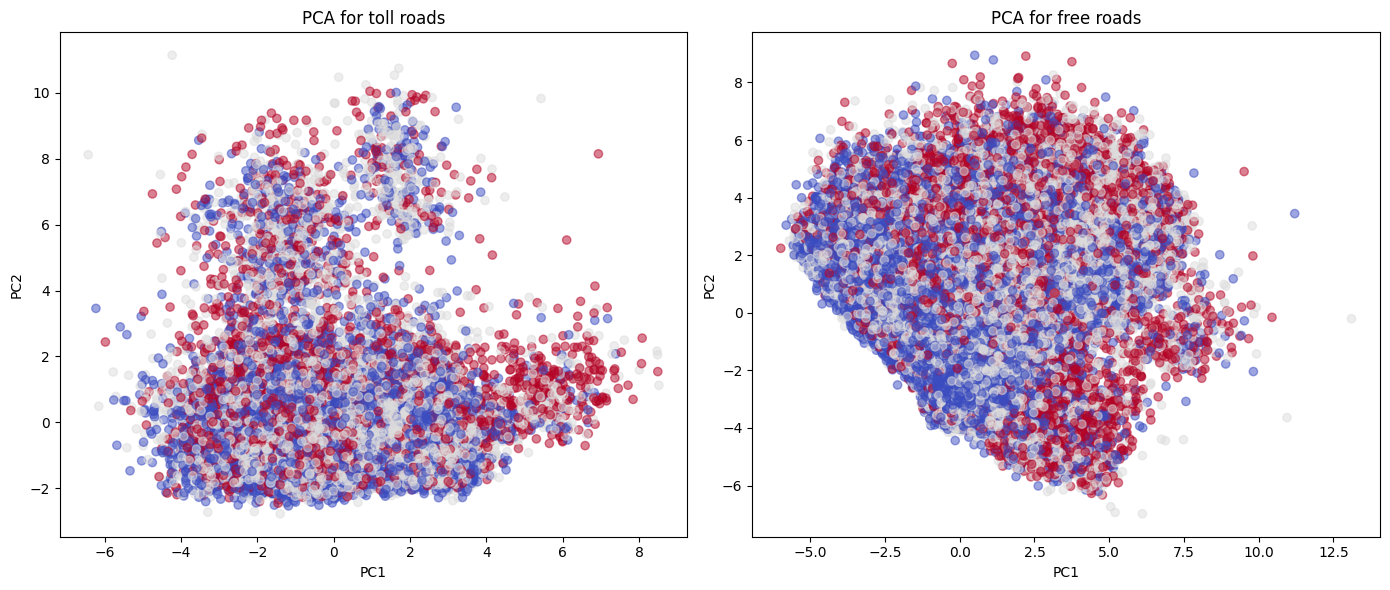

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca_toll[:,0], X_pca_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)
axes[0].set_title("PCA for toll roads")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca_free[:,0], X_pca_free[:,1], c=y_free, cmap='coolwarm', alpha=0.5)
axes[1].set_title("PCA for free roads")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

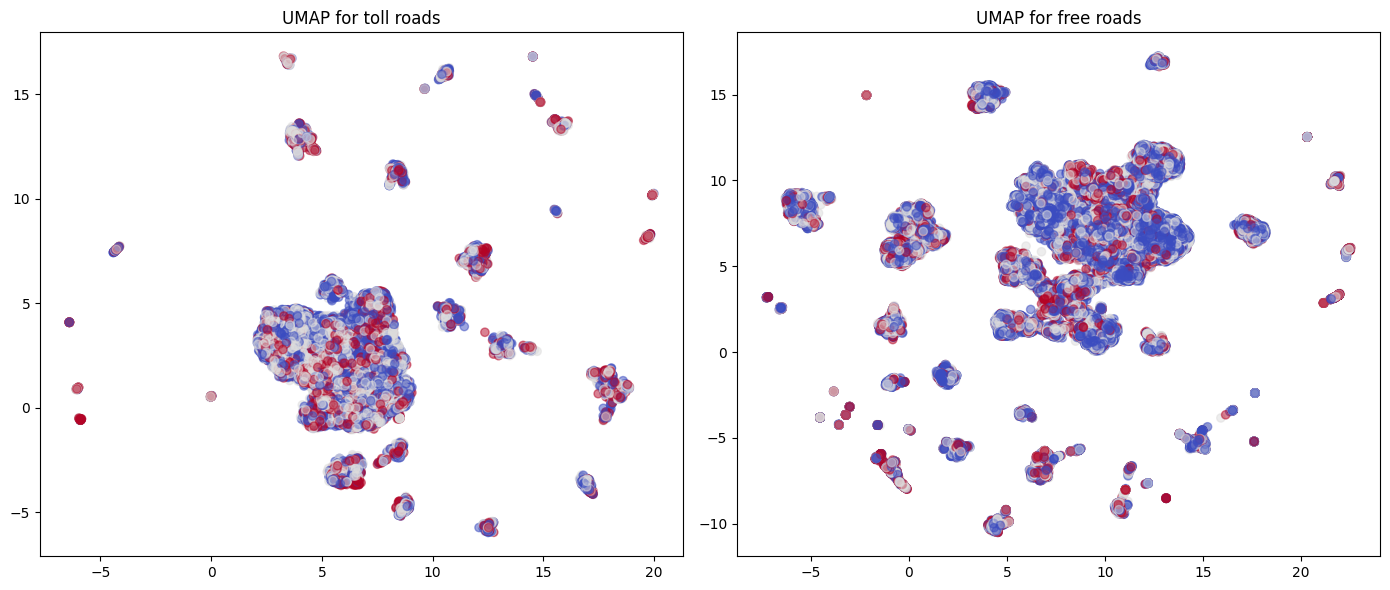

In [51]:
reducer = umap.UMAP()
X_umap_toll = reducer.fit_transform(X_scaled_toll)

reducer = umap.UMAP()
X_umap_free = reducer.fit_transform(X_scaled_free)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_umap_toll[:,0], X_umap_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)
axes[0].set_title("UMAP for toll roads")

axes[1].scatter(X_umap_free[:,0], X_umap_free[:,1], c=y_free, cmap='coolwarm', alpha=0.5)
axes[1].set_title("UMAP for free roads")

plt.tight_layout()
plt.show()

#### Continue testing the hypothesis

Let's choose the most important fearures for analysis.

In [49]:
threshold = 0.01

# -------------------

importances_toll = rf_toll.feature_importances_
feature_names = X_toll.columns

importances_df_toll = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_toll
})

# filter out unimportant features except 'is_toll'
low_importance_features = importances_df_toll[
    (importances_df_toll['importance'] < threshold) & 
    (importances_df_toll['feature'] != 'is_toll')
]['feature'].tolist()

X_toll_filtered = X_toll.drop(columns=low_importance_features)

# -------------------

importances_free = rf_free.feature_importances_
feature_names = X_free.columns

importances_df_free = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_free
})

low_importance_features = importances_df_free[
    (importances_df_free['importance'] < threshold) & 
    (importances_df_free['feature'] != 'is_toll')
]['feature'].tolist()

X_free_filtered = X_free.drop(columns=low_importance_features)

In [53]:
y_toll = df_toll['severity'] - 1
y_free = df_free['severity'] - 1

xgb_toll = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_toll.fit(X_toll_filtered, y_toll)

xgb_free = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_free.fit(X_free_filtered, y_free)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [56]:
proba_toll = xgb_toll.predict_proba(X_toll_filtered)
proba_free = xgb_free.predict_proba(X_free_filtered)

avg_proba_toll = np.mean(proba_toll, axis=0)
avg_proba_free = np.mean(proba_free, axis=0)

print("Toll roads vs free roads\n")
print(f"'Light' severity:  {avg_proba_toll[0]:3f} | {avg_proba_free[0]:3f}")
print(f"'Medium' severity:  {avg_proba_toll[1]:3f} | {avg_proba_free[1]:3f}")
print(f"'Severe' severity:  {avg_proba_toll[2]:3f} | {avg_proba_free[2]:3f}")

Toll roads vs free roads

'Light' severity:  0.405530 | 0.442587
'Medium' severity:  0.408872 | 0.390140
'Severe' severity:  0.185599 | 0.167261


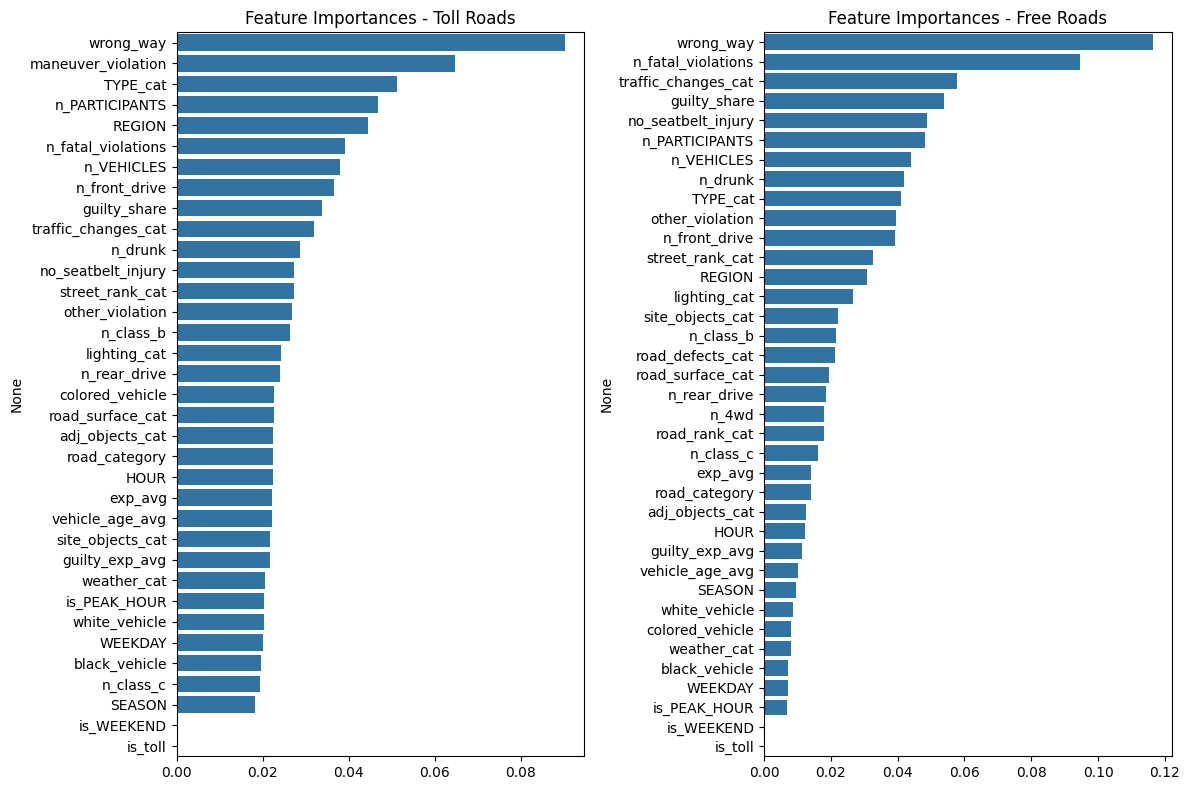

In [55]:
# Feature importances
importances_toll = pd.Series(xgb_toll.feature_importances_, index=X_toll_filtered.columns).sort_values(ascending=False)
importances_free = pd.Series(xgb_free.feature_importances_, index=X_free_filtered.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()

Hypothesis 1 is supported, as toll roads have a higher probability of severe accidents.

Hypothesis 2 is also supported by differences in the features that influence the severity of accidents on toll and free roads.